## PlasmoData.jl Tutorial

This notebook will walk through how to use PlasmoData.jl for modeling data as graphs. [PlasmoData.jl](https://github.com/zavalab/PlasmoData.jl) is open-source Julia package that represents data as graphs and enables storing data within the graph structure. There is also an accompanying package [DataGraphPlots.jl](https://github.com/zavalab/DataGraphPlots.jl) that can be used for visualizing the graphs defined in PlasmoData.jl. 

PlasmoData.jl is built on the data structure called `DataGraph`s for undirected graphs (or `DataDiGraph`s for directed graphs). `DataGraph`s have the following attributes. PlasmoData.jl also stores the `SimpleGraph` (or `SimpleDiGraph`) strucutre from Graphs.jl, which enables extending many functions from Graphs.jl.

 * `g`: `SimpleGraph` (or `SimpleDiGraph` for directed graphs) containing the graph structure.
 * `nodes`: A vector of nodes, where the entries of the vector are node names. These names are of type `Any` so that the nodes can use a variety of naming conventions (strings, symbols, tuples, etc.)
 * `edges`: A vector of tuples, where each tuple contains two entries, where each entry relates to a node. 
 * `node_map`: A dictionary that maps the node names to their index in the `nodes` vector
 * `edge_map`: A dictionary that maps the edges to their index in the `edges` vector.
 * `node_data`: An object of type `NodeData` that includes a matrix of data, where the first dimension of the matrix corresponds to the node, and the second dimension corresponds to attributes for the nodes. Any number of attributes is allowed, and `NodeData` also includes attribute names and a mapping of the attribute name to the column of the data matrix. 
 * `edge_data`: An object of type `EdgeData` that includes a matrix of data, where the first dimension fo the matrix corresponds to the edges, and the second dimension corresponds to attributes for the edges. Any number of attributes is allowed, and `EdgeData` also includes attribute names and a mapping of the attribute name to the column of the data matrix. 
 * `graph_data`: An object of type `GraphData` that includes a vector of data whose dimension corresponds to the number of attributes for the graph. Any number of attributes is allowed, and `GraphData` also includes attribute names and a mapping of the attribute name to the entry in the vector. 

PlasmoData.jl provides an API for interfacing with the `DataGraph` data strucutre. In this notebook, we will walk through how to use this API and different functions for modeling data as graphs and analyzing that data using different tools, including different tools in topological data analysis. Documentation is available for PlasmoData [here](https://zavalab.github.io/PlasmoData.jl/dev/) or through using `?` for specific functions, such as `?matrix_to_graph`.

### Manually Constructing a Graph

All nodes in `DataGraph`s are named in some way. Anything (`String`s, `Int`s, `Tuple`s, etc.) can be used for node names. Edges are added by indicating nodes that are the source and destination of the edge (in the case of `DataDiGraph`s, the order of nodes as source and destinations is important). 

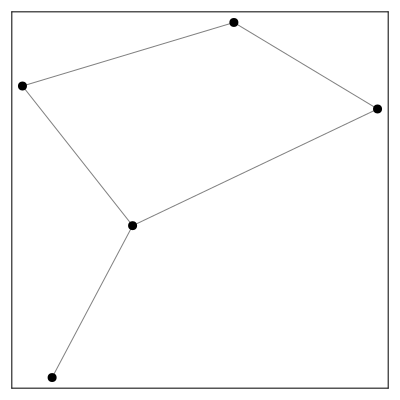

In [1]:
using PlasmoData, Graphs, Random, Plots, DataGraphPlots

#Initialize DataGraph
dg = DataGraph()

# Add nodes; any node name is valid as long as it's not in the graph already
# Follows format add_node!(DataGraph, node name)
add_node!(dg, "Node 1")
add_node!(dg, :Node2)
add_node!(dg, 3)
add_node!(dg, 4.0)
add_node!(dg, "Node 5")

# Add edges
# Follows format add_edge!(DataGraph, (node_name1, node_name2)) or 
# add_edge!(DataGraph, node_name1, node_name2)

PlasmoData.add_edge!(dg, ("Node 1", "Node 5"))
PlasmoData.add_edge!(dg, ("Node 1", :Node2))
PlasmoData.add_edge!(dg, (:Node2, 3))
PlasmoData.add_edge!(dg, 3, 4.0)
PlasmoData.add_edge!(dg, 3, "Node 5")

# graph can be plotted with DataGraphPlots.jl function plot_graph
plt = plot_graph(dg, xdim = 400, ydim = 400)

# Data can be added to any node or edge; any data must be saved under an attribute name
# Attribute names are always given as strings
# Data is added using the format add_node_data!(DataGraph, node_name, node_data, attribute_name)
# When a new attribute is defined, all other nodes initialize with a value of 0 for that attribute

add_node_data!(dg, "Node 1", 7.2, "Weight1")
add_node_data!(dg, :Node2, 8.4, "Weight1")
add_node_data!(dg, 3, 6.2, "Weight1")
add_node_data!(dg, 4.0, 4.4, "Weight1")
add_node_data!(dg, "Node 5", 5.5, "Weight1")

# Edge data is added in a similar way; for undirected graphs, order of the edge does not matter

add_edge_data!(dg, ("Node 1", "Node 5"), .16, "Weight1")
add_edge_data!(dg, :Node2, "Node 1", .85, "Weight1")
add_edge_data!(dg, (:Node2, 3), .44, "Weight1")
add_edge_data!(dg, 4.0, 3, .23, "Weight1")
add_edge_data!(dg, (3, "Node 5"), .22, "Weight1");

### Data Representations as Graphs

Many data structures can be represented as graphs. These representations are enabled within PlasmoData.jl. For example, a matrix can be represented as a node-weighted graph where each matrix entry can be represented as a node and edges are placed between adjacent entries of a matrix. Values of the matrix are saved as weights on their corresponding nodes. Similarly, tensors can be represented as a graph, but "adjacent entries" now lie in multiple dimensions. Symmetric matrices (such as a correlation matrix) can also be represented as a graph, but as an edge-weighted graph rather than a node weighted graph. In this case, the dimension of the symmetric matrix is equal to the number of nodes in the graph, and each node is connected to all other nodes. Matrix entry $(i, j)$ contains the edge weight between node $i$ and node $j$. All these representations are easily enabled in PlasmoData.jl

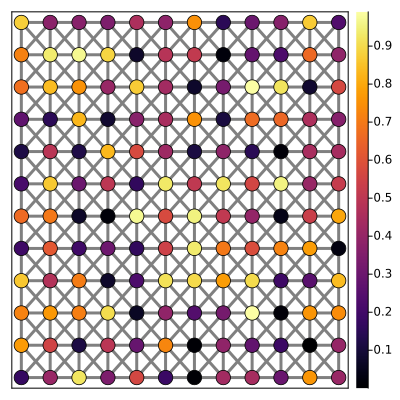

In [2]:
# matrices can be represented as graphs by calling matrix_to_graph(matrix)
# If diagonal = false, edges will only be added to the adjacent entries. Default is that diagonal = true
# and diagonals are added to the nodes that are diagonal to each matrix entry

Random.seed!(10)
random_matrix = rand(12, 12)
matrix_graph = matrix_to_graph(random_matrix, diagonal = true);
set_matrix_node_positions!(matrix_graph, random_matrix)
mat_graph_plot = plot_graph(
    matrix_graph, 
    node_z = get_node_data(matrix_graph, "weight"), 
    xdim = 400, 
    ydim = 400, 
    legend = true,
    nodesize = 8,
    linewidth = 3
);

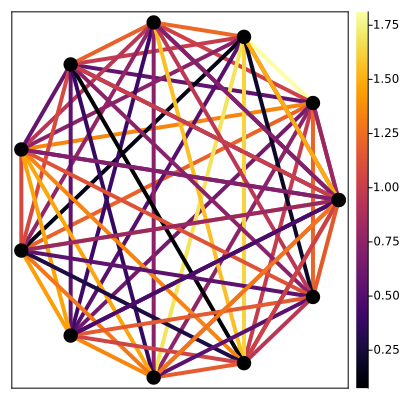

In [3]:
# Symmetric Matrices can be handled in similar ways

sym_matrix = random_matrix .+ random_matrix'

sym_graph = symmetric_matrix_to_graph(sym_matrix)

# For plotting purposes, we will define the node positions manually;
# These are saved as node attributes called "x_positions" and "y_positions"

sym_nodes = sym_graph.nodes
for (i, val) in enumerate(LinRange(0, 2*pi, 12))
    add_node_data!(sym_graph, sym_nodes[i], cos(val), "x_positions")
    add_node_data!(sym_graph, sym_nodes[i], sin(val), "y_positions")
end

plot_graph(
    sym_graph,
    line_z = get_edge_data(sym_graph, "weight"),
    linewidth = 4,
    nodesize = 8,
    legend = true,
    xdim = 400,
    ydim = 400
);

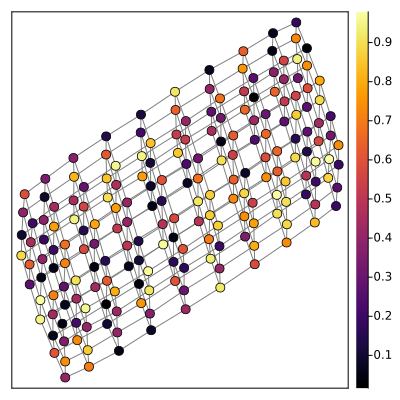

In [4]:
# Tensors follow a similar pattern using the function tensor_to_graph(DataGraph, tensor)

random_tensor = rand(5, 4, 10)

tensor_graph = tensor_to_graph(random_tensor)

plot_graph(
    tensor_graph,
    node_z = get_node_data(tensor_graph, "weight"),
    xdim = 400,
    ydim = 400,
    legend = true
);

### Manipulating Graph Struture

PlasmoData also allows for changing the graph structure, such as aggregating a set of nodes or through filtering the nodes or edges based on weight values. PlasmoData provides functions including `aggregate`, `filter_nodes`, and `filter_edges`.

AGGREGATED GRAPH


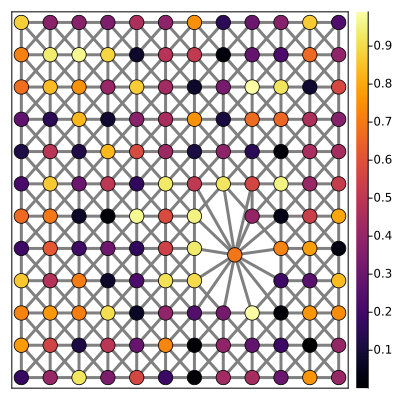

FILTERED GRAPH


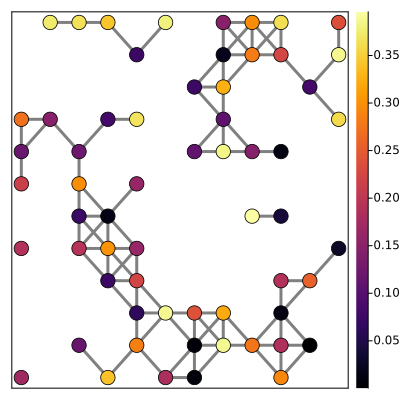

GRAPH WITH NODES AND EDGES REMOVED


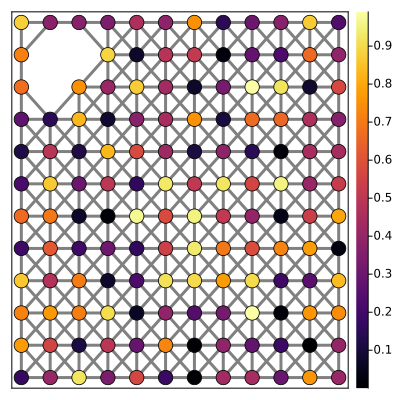

In [5]:
# Aggregate returns a new DataGraph where a set of nodes are aggregated into a single new node
# Note that node names from matrix_to_graph are tuples containing the matrix indices

agg_graph = aggregate(
    matrix_graph, 
    [(7, 8), (8, 8), (8, 9), (9, 8), (9, 9)], # List of nodes to aggregate
    "new node"
)

println("AGGREGATED GRAPH")
plot_graph(
    agg_graph, 
    node_z = get_node_data(agg_graph, "weight"), 
    xdim = 400, 
    ydim = 400, 
    legend = true,
    nodesize = 8,
    linewidth = 3
);

# filter_nodes filters out all nodes whose node attribute is false for a given function, fn

filtered_graph1 = filter_nodes(matrix_graph, .4, "weight", fn = Base.isless)

println("FILTERED GRAPH")

plot_graph(
    filtered_graph1,
    node_z = get_node_data(filtered_graph1, "weight"), 
    xdim = 400, 
    ydim = 400, 
    legend = true,
    nodesize = 8,
    linewidth = 3
);

# Nodes and edges can also be manually altered by calling remove_node! or remove_edge!
# Note that these functions change the graph in place while aggregate and filter_nodes returns a new graph

remove_node!(matrix_graph, (2, 2))
remove_node!(matrix_graph, (3, 2))
remove_node!(matrix_graph, (2, 3))

#remove_edge!(matrix_graph, (2, 11), (1, 12))
#remove_edge!(matrix_graph, (1, 11), (2, 12))

println("GRAPH WITH NODES AND EDGES REMOVED")
mat_graph_plot = plot_graph(
    matrix_graph, 
    node_z = get_node_data(matrix_graph, "weight"), 
    xdim = 400, 
    ydim = 400, 
    legend = true,
    nodesize = 8,
    linewidth = 3
);

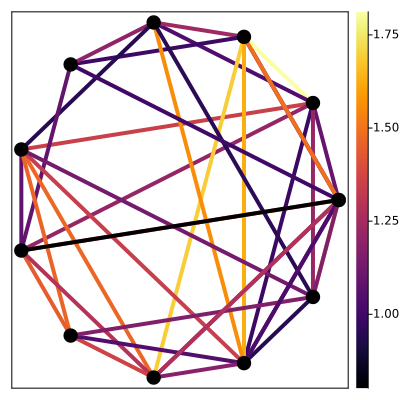

In [6]:
# filter_edges works in an identical way

filtered_graph2 = filter_edges(sym_graph, .8, "weight", fn = Base.isgreater)

plot_graph(
    filtered_graph2,
    line_z = get_edge_data(filtered_graph2, "weight"),
    linewidth = 4,
    nodesize = 8,
    legend = true,
    xdim = 400,
    ydim = 400
);

### Topological Data Analysis

A major benefit from modeling data with graphs is that graphs are topologically invariant and their topology can give insights into the data (in contrast, a matrix does not have "topology"). By extending Graphs.jl, many topological metrics are easily computed within PlasmoData.jl (including for graphs whose structure has been manipulated, such as after filtration or aggregation). 

Topological descriptors describe the "shape" of the graph or the "shape" of the data. For example, metrics like the number of connected components, number of cycles, or the average node degree describe how the graph is connected. 

In [7]:
# Many Graphs.jl functions have been extended to work with DataGraphs, so they can be called directly on DataGraph objects
# For functions that have not been extended, the Graphs.SimpleGraph object can be accessed from the DataGraph object

println("The number of cycles is ", length(Graphs.cycle_basis(filtered_graph1)))
println("The average node degree is ", length(average_degree(filtered_graph1)))
println("The number of connected components is ", length(Graphs.connected_components(filtered_graph1)))
println("The number of communities from k = 3 clique percolation is ", length(Graphs.clique_percolation(filtered_graph1)))


# general topological descriptors; clique filtration, average degree; number of cycles; number of connected components; EC
# run EC on nodes
# run EC on edges; show plot; show filtered graph at different points

The number of cycles is 37
The average node degree is 1
The number of connected components is 6
The number of communities from k = 3 clique percolation is 7


### Euler Characteristic


Another metric available is the Euler Characteristic (EC), which can be applied to a variety of geometric objects. For graphs, the EC is equivalent to the number of connected components minus the number of cycles (or equivalently, the number of nodes minus the number of edges). A paper detailing the EC and some of its applications can be found [here](https://doi-org.ezproxy.library.wisc.edu/10.1016/j.compchemeng.2021.107463). The EC can be computed within PlasmoData.jl.

The EC can be combined with filtration to produce an EC curve. The EC curve shows how fast the topology changes when nodes or edges are filtered from a graph at different threshold values. Within PlasmoData.jl, the EC curve can be computed by calling `run_EC_on_edges` or `run_EC_on_nodes`, which takes a `DataGraph` and an iterable of threshold values for filtration.

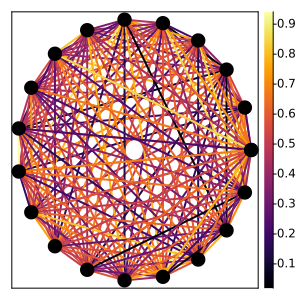

In [8]:
Random.seed!(10)

rand_mat = rand(20, 20)

sym_mat = (rand_mat .+ rand_mat')/2

sym_graph = symmetric_matrix_to_graph(sym_mat)

sym_nodes = sym_graph.nodes
for (i, val) in enumerate(LinRange(0, 2*pi, 20))
    add_node_data!(sym_graph, sym_nodes[i], cos(val), "x_positions")
    add_node_data!(sym_graph, sym_nodes[i], sin(val), "y_positions")
end

plot_graph(
    sym_graph,
    line_z = get_edge_data(sym_graph, "weight"),
    linewidth = 2,
    nodesize = 8,
    legend = true,
    xdim = 300,
    ydim = 300
);

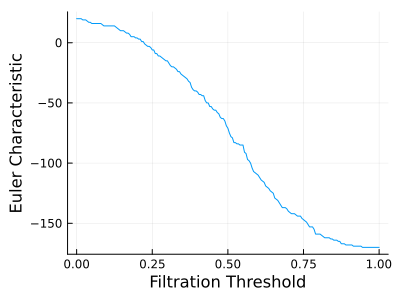

In [9]:
filtration_threshold = 0:.005:1

EC_curve = run_EC_on_edges(sym_graph, filtration_threshold)

plt = plot(filtration_threshold, EC_curve, size = (400, 300), label = :none)
xlabel!("Filtration Threshold")
ylabel!("Euler Characteristic")
display(plt);

You can visualize the filtered graph at $0.25$, $0.50$, and $0.75$ by calling `filter_edges` as shown below. 

FILTERED GRAPH AT 0.25


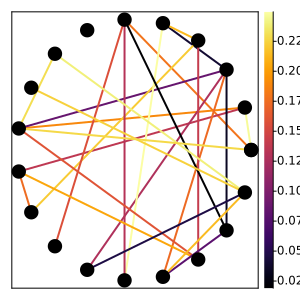

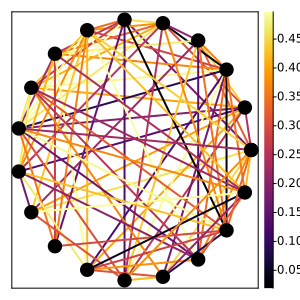

FILTERED GRAPH AT 0.75


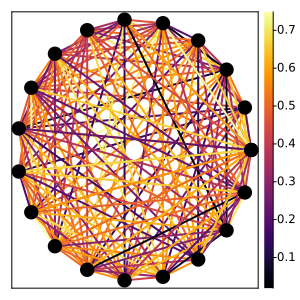

In [10]:
filtered_graph25 = filter_edges(sym_graph, .25)

println("FILTERED GRAPH AT 0.25")
plot_graph(
    filtered_graph25,
    line_z = get_edge_data(filtered_graph25, "weight"),
    linewidth = 2,
    nodesize = 8,
    legend = true,
    xdim = 300,
    ydim = 300
);

filtered_graph50 = filter_edges(sym_graph, .5)

plot_graph(
    filtered_graph50,
    line_z = get_edge_data(filtered_graph50, "weight"),
    linewidth = 2,
    nodesize = 8,
    legend = true,
    xdim = 300,
    ydim = 300
);

filtered_graph75 = filter_edges(sym_graph, .75)

println("FILTERED GRAPH AT 0.75")
plot_graph(
    filtered_graph75,
    line_z = get_edge_data(filtered_graph75, "weight"),
    linewidth = 2,
    nodesize = 8,
    legend = true,
    xdim = 300,
    ydim = 300
);

### Processing Data

These graph-based representations can be useful for a variety of datasets. However, in many cases, the data must be placed into a form that matches these graph representations. For example, a grayscale image can be represented as a matrix, where each matrix entry corresponds to a pixel, and the value of the matrix entry corresponds to the pixel shading. For color images, there are often three channels of values for each pixel (e.g., RGB), so this could correspond to three weights on each pixel (node). Similarly, videos can be represented as tensors (and thus passed to `tensor_to_graph` as shown above). Other datasets may require other types of processing to convert into a form enabling graph representations; for example, a time series dataset could be converted to a symmetric matrix by computing the correlation matrix for the time series (such as using `Statistics.cor`).
